# Autotalker Batch Integration

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 20.01.2023
- **Date of Last Modification:** 23.01.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../autotalker")

In [3]:
import argparse
import os
import random
import warnings
from copy import deepcopy
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq
import torch
from matplotlib.pyplot import rc_context

from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps)

### 1.2 Define Parameters

In [36]:
## Dataset
dataset = "seqfish_mouse_organogenesis"
batch1 = "embryo1_rep1"
batch2 = "embryo1_rep2"
batch3 = "embryo2_rep1"
batch4 = "embryo2_rep2"
batch5 = "embryo3_rep1"
batch6 = "embryo3_rep2"
n_neighbors = 12

## Model
# AnnData Keys
counts_key = "counts"
cell_type_key = "celltype_mapped_refined"
adj_key = "spatial_connectivities"
spatial_key = "spatial"
gp_names_key = "autotalker_gp_names"
active_gp_names_key = "autotalker_active_gp_names"
gp_targets_mask_key = "autotalker_gp_targets"
gp_sources_mask_key = "autotalker_gp_sources"
latent_key = "autotalker_latent"
condition_key = "batch"

# Architecture
active_gp_thresh_ratio = 0.03
gene_expr_recon_dist = "nb"

# Trainer
n_epochs = 20
n_epochs_all_gps = 10
lr = 0.001

## Others
random_seed = 42

### 1.3 Run Notebook Setup

In [37]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [38]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Create Directories

In [39]:
# Define paths
figure_folder_path = f"../figures/{dataset}/batch_integration/{current_timestamp}"
model_artifacts_folder_path = f"../artifacts/{dataset}/batch_integration/{current_timestamp}"
gp_data_folder_path = "../datasets/gp_data" # gene program data
srt_data_folder_path = "../datasets/srt_data" # spatially resolved transcriptomics data
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"

# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(model_artifacts_folder_path, exist_ok=True)

## 2. Data

### 2.1 Load Data & Compute Spatial Neighbor Graph

In [40]:
adata_batch1 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch1}.h5ad")
adata_batch2 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch2}.h5ad")
adata_batch3 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch3}.h5ad")
adata_batch4 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch4}.h5ad")
adata_batch5 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch5}.h5ad")
adata_batch6 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch6}.h5ad")

adata_batch_list = [adata_batch1,
                    adata_batch2,
                    adata_batch3,
                    adata_batch4,
                    adata_batch5,
                    adata_batch6]

In [41]:
for adata_batch in adata_batch_list:
    # Compute (separate) spatial neighborhood
    sq.gr.spatial_neighbors(adata_batch,
                            coord_type="generic",
                            spatial_key=spatial_key,
                            n_neighs=n_neighbors)
    # Make adjacency matrix symmetric
    adata_batch.obsp["spatial_connectivities"] = adata_batch.obsp["spatial_connectivities"].maximum(
        adata_batch.obsp["spatial_connectivities"].T)

In [42]:
# Combine adata
adata = ad.concat(adata_batch_list, join="inner")

# Combine spatial neighborhood graphs as disconnected components
connectivities_extension_batch1 = sp.csr_matrix((adata_batch1.shape[0],
                                                 (adata_batch2.shape[0] +
                                                  adata_batch3.shape[0] +
                                                  adata_batch4.shape[0] +
                                                  adata_batch5.shape[0] +
                                                  adata_batch6.shape[0])))
connectivities_extension_batch2_before = sp.csr_matrix((adata_batch2.shape[0],
                                                        adata_batch1.shape[0]))
connectivities_extension_batch2_after = sp.csr_matrix((adata_batch2.shape[0],
                                                       (adata_batch3.shape[0] +
                                                        adata_batch4.shape[0] +
                                                        adata_batch5.shape[0] +
                                                        adata_batch6.shape[0])))
connectivities_extension_batch3_before = sp.csr_matrix((adata_batch3.shape[0],
                                                        (adata_batch1.shape[0] +
                                                         adata_batch2.shape[0])))
connectivities_extension_batch3_after = sp.csr_matrix((adata_batch3.shape[0],
                                                       (adata_batch4.shape[0] +
                                                        adata_batch5.shape[0] +
                                                        adata_batch6.shape[0])))
connectivities_extension_batch4_before = sp.csr_matrix((adata_batch4.shape[0],
                                                        (adata_batch1.shape[0] +
                                                         adata_batch2.shape[0] +
                                                         adata_batch3.shape[0])))
connectivities_extension_batch4_after = sp.csr_matrix((adata_batch4.shape[0],
                                                       (adata_batch5.shape[0] +
                                                        adata_batch6.shape[0])))
connectivities_extension_batch5_before = sp.csr_matrix((adata_batch5.shape[0],
                                                        (adata_batch1.shape[0] +
                                                         adata_batch2.shape[0] +
                                                         adata_batch3.shape[0] +
                                                         adata_batch4.shape[0])))
connectivities_extension_batch5_after = sp.csr_matrix((adata_batch5.shape[0],
                                                       adata_batch6.shape[0]))
connectivities_extension_batch6 = sp.csr_matrix((adata_batch6.shape[0],
                                                 (adata_batch1.shape[0] +
                                                  adata_batch2.shape[0] +
                                                  adata_batch3.shape[0] +
                                                  adata_batch4.shape[0] +
                                                  adata_batch5.shape[0])))

connectivities_batch1 = sp.hstack((adata_batch1.obsp["spatial_connectivities"],
                                   connectivities_extension_batch1))
connectivities_batch2 = sp.hstack((connectivities_extension_batch2_before,
                                   adata_batch2.obsp["spatial_connectivities"],
                                   connectivities_extension_batch2_after))
connectivities_batch3 = sp.hstack((connectivities_extension_batch3_before,
                                   adata_batch3.obsp["spatial_connectivities"],
                                   connectivities_extension_batch3_after))
connectivities_batch4 = sp.hstack((connectivities_extension_batch4_before,
                                   adata_batch4.obsp["spatial_connectivities"],
                                   connectivities_extension_batch4_after))
connectivities_batch5 = sp.hstack((connectivities_extension_batch5_before,
                                   adata_batch5.obsp["spatial_connectivities"],
                                   connectivities_extension_batch5_after))
connectivities_batch6 = sp.hstack((connectivities_extension_batch6,
                                   adata_batch6.obsp["spatial_connectivities"]))

connectivities = sp.vstack((connectivities_batch1,
                            connectivities_batch2,
                            connectivities_batch3,
                            connectivities_batch4,
                            connectivities_batch5,
                            connectivities_batch6))

adata.obsp["spatial_connectivities"] = connectivities

## 3. Autotalker Model

### 3.1 Prepare Gene Program Mask

In [43]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.01,
    load_from_disk=True,
    save_to_disk=False,
    file_path=nichenet_ligand_target_mx_file_path)

In [44]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    file_path=omnipath_lr_interactions_file_path)

In [45]:
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps/",
    species="mouse",
    genes_uppercase=True)

In [46]:
# Combine gene programs into one dictionary
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [47]:
# Filter and combine gene programs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9,
    verbose=True)

print(f"Number of gene programs before filtering and combining: {len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: {len(combined_new_gp_dict)}.")

Removing GP 'CTF1_ligand_receptor_GP' as it is a subset of GP 'CTF1_ligand_targetgenes_GP'.
Removing GP 'LEP_ligand_receptor_GP' as it is a subset of GP 'LEP_ligand_targetgenes_GP'.
Removing GP 'IL4_ligand_receptor_GP' as it is a subset of GP 'IL4_ligand_targetgenes_GP'.
Removing GP 'IL12A_ligand_receptor_GP' as it is a subset of GP 'IL12A_ligand_targetgenes_GP'.
Removing GP 'IL23A_ligand_receptor_GP' as it is a subset of GP 'IL23A_ligand_targetgenes_GP'.
Removing GP 'CSF2_ligand_receptor_GP' as it is a subset of GP 'CSF2_ligand_targetgenes_GP'.
Removing GP 'IL21_ligand_receptor_GP' as it is a subset of GP 'IL21_ligand_targetgenes_GP'.
Removing GP 'TSLP_ligand_receptor_GP' as it is a subset of GP 'TSLP_ligand_targetgenes_GP'.
Removing GP 'GH2_ligand_receptor_GP' as it is a subset of GP 'GH2_ligand_targetgenes_GP'.
Removing GP 'EGF_ligand_receptor_GP' as it is a subset of GP 'EGF_ligand_targetgenes_GP'.
Removing GP 'IL10_ligand_receptor_GP' as it is a subset of GP 'IL10_ligand_targetgen

In [48]:
# Add the gene program dictionary as binary masks to the adata for model training
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata,
    genes_uppercase=True,
    gp_targets_mask_key="autotalker_gp_targets",
    gp_sources_mask_key="autotalker_gp_sources",
    gp_names_key="autotalker_gp_names",
    min_genes_per_gp=1,
    min_source_genes_per_gp=0,
    min_target_genes_per_gp=0,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None,
    filter_genes_not_in_masks=False)

# Determine dimensionality of hidden encoder
n_hidden_encoder = len(adata.uns["autotalker_gp_names"])

In [49]:
# Summarize gene programs
print(f"Number of gene programs with probed genes: {len(adata.uns['autotalker_gp_names'])}.")
print(f"Example gene programs: {random.sample(list(adata.uns['autotalker_gp_names']), 5)}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_gp_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_gp_sources'].sum()}.")

Number of gene programs with probed genes: 489.
Example gene programs: ['WNT4_ligand_targetgenes_GP', 'BMP6_ligand_targetgenes_GP', 'FGF9_ligand_receptor_GP', 'UCN2_ligand_targetgenes_GP', 'SHH_ligand_targetgenes_GP'].
Number of gene program target genes: 7476.
Number of gene program source genes: 127.


### 3.2 Autotalker Model Without Batch Integration

#### 3.2.1 Initialize, Train & Save Model

In [50]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            verbose=True)

--- INITIALIZING TRAINER ---
Number of training nodes: 47311
Number of validation nodes: 5257
Number of training edges: 109836
Number of validation edges: 12204

--- MODEL TRAINING ---
Epoch 1/20 |█-------------------| 5.0% val_auroc_score: 0.9927; val_auprc_score: 0.9873; val_best_acc_score: 0.9292; val_best_f1_score: 0.9338; train_kl_reg_loss: 0.2755; train_edge_recon_loss: 1.2697; train_gene_expr_recon_loss: 89.3781; train_group_lasso_reg_loss: 0.0000; train_global_loss: 90.9233; train_optim_loss: 90.9233; val_kl_reg_loss: 0.2741; val_edge_recon_loss: 1.2365; val_gene_expr_recon_loss: 90.3280; val_group_lasso_reg_loss: 0.0000; val_global_loss: 91.8385; val_optim_loss: 91.8385
Epoch 2/20 |██------------------| 10.0% val_auroc_score: 0.9929; val_auprc_score: 0.9881; val_best_acc_score: 0.9331; val_best_f1_score: 0.9372; train_kl_reg_loss: 0.2865; train_edge_recon_loss: 1.2141; train_gene_expr_recon_loss: 89.2914; train_group_lasso_reg_loss: 0.0000; train_global_loss: 90.7920; train_op

In [51]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/unintegrated",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

#### 3.2.2 Analyze Latent Space

In [52]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key)
sc.tl.umap(model.adata)

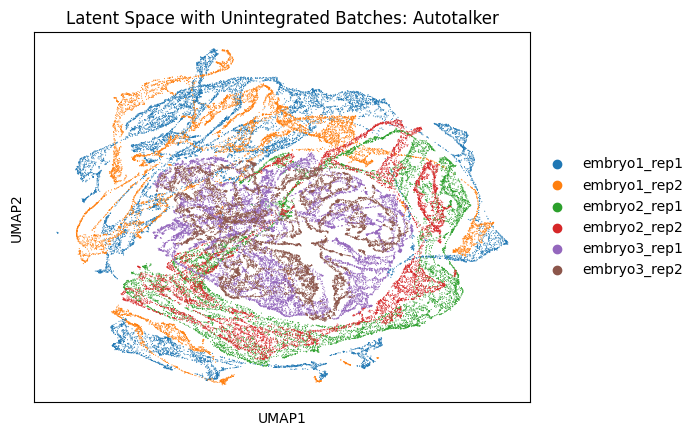

In [53]:
# Plot UMAP with batch annotation
fig = sc.pl.umap(model.adata,
                 color=[condition_key],
                 title="Latent Space with Unintegrated Batches: Autotalker",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_autotalker_batches_unintegrated.png",
            bbox_inches="tight")

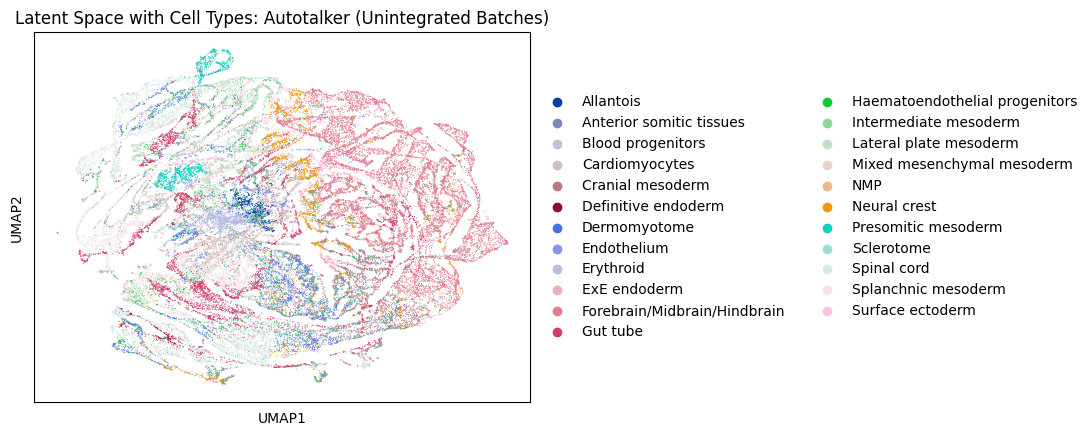

In [54]:
# Plot UMAP with cell type annotation
fig = sc.pl.umap(model.adata,
                 color=[cell_type_key],
                 title="Latent Space with Cell Types: Autotalker (Unintegrated Batches)",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_autotalker_cell_types_unintegrated.png",
            bbox_inches="tight")

### 3.3 Autotalker Model With Decoder Batch Integration

#### 3.3.1 Initialize, Train & Save Model

In [55]:
# Initialize model
model = Autotalker(adata,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   condition_key=condition_key,
                   cond_embed_injection=["gene_expr_decoder",
                                         "graph_decoder"],
                   n_cond_embed=100,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   n_hidden_encoder=n_hidden_encoder,
                   n_addon_gps=0,
                   node_label_method="one-hop-attention")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> ['gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 351, n_cond_embed_input: 0, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 100, n_output: 489, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_cond_embed_input: 100, n_addon_input: 0, n_output: 702


In [56]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            verbose=True)

--- INITIALIZING TRAINER ---
Number of training nodes: 47311
Number of validation nodes: 5257
Number of training edges: 319410
Number of validation edges: 35490

--- MODEL TRAINING ---
Epoch 1/20 |█-------------------| 5.0% val_auroc_score: 0.9828; val_auprc_score: 0.9675; val_best_acc_score: 0.9161; val_best_f1_score: 0.9226; train_kl_reg_loss: 0.0587; train_edge_recon_loss: 1.5298; train_gene_expr_recon_loss: 99.4689; train_group_lasso_reg_loss: 0.0000; train_global_loss: 101.0575; train_optim_loss: 101.0575; val_kl_reg_loss: 0.0770; val_edge_recon_loss: 1.4603; val_gene_expr_recon_loss: 93.8629; val_group_lasso_reg_loss: 0.0000; val_global_loss: 95.4002; val_optim_loss: 95.4002
Epoch 2/20 |██------------------| 10.0% val_auroc_score: 0.9901; val_auprc_score: 0.9811; val_best_acc_score: 0.9351; val_best_f1_score: 0.9390; train_kl_reg_loss: 0.0845; train_edge_recon_loss: 1.2413; train_gene_expr_recon_loss: 93.3899; train_group_lasso_reg_loss: 0.0000; train_global_loss: 94.7157; train_

In [57]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/integrated_decoder",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

#### 3.3.2 Analyze Latent Space

In [58]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key)
sc.tl.umap(model.adata)

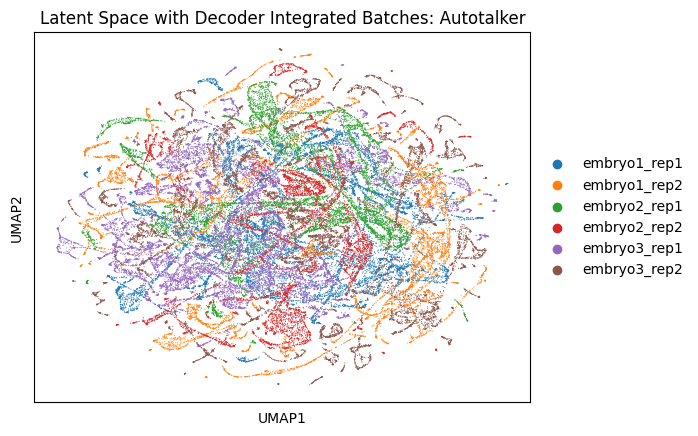

In [59]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(model.adata,
                 color=[condition_key],
                 title="Latent Space with Decoder Integrated Batches: Autotalker",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_autotalker_batches_integrated_decoder.png",
            bbox_inches="tight")

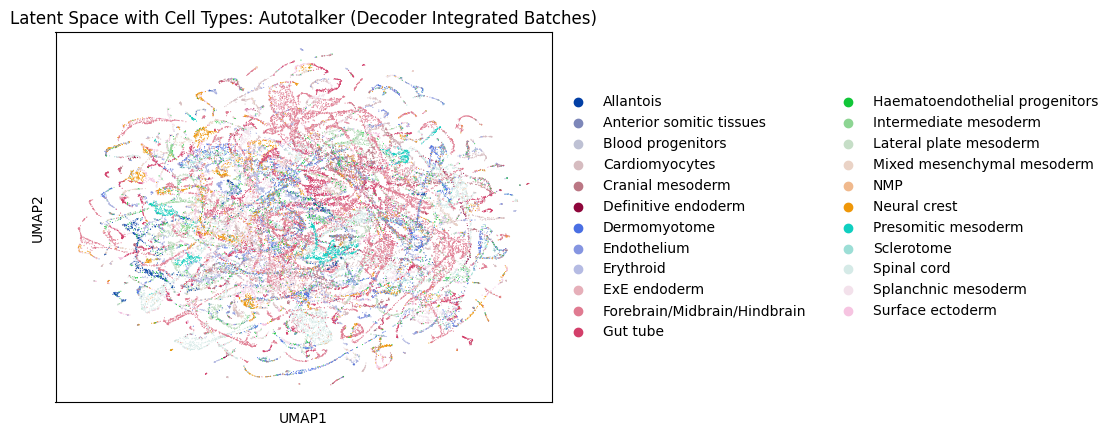

In [60]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 color=[cell_type_key],
                 title="Latent Space with Cell Types: Autotalker (Decoder Integrated Batches)",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_autotalker_cell_types_integrated_decoder.png",
            bbox_inches="tight")

#### 3.3.3 Analyze Conditional Embedding

In [61]:
# Get conditional embeddings
cond_embed = model.get_conditional_embeddings()
adata_cond_embed = ad.AnnData(cond_embed)
adata_cond_embed.obs["batch"] = adata.obs["batch"].unique()

         Falling back to preprocessing with `sc.pp.pca` and default params.


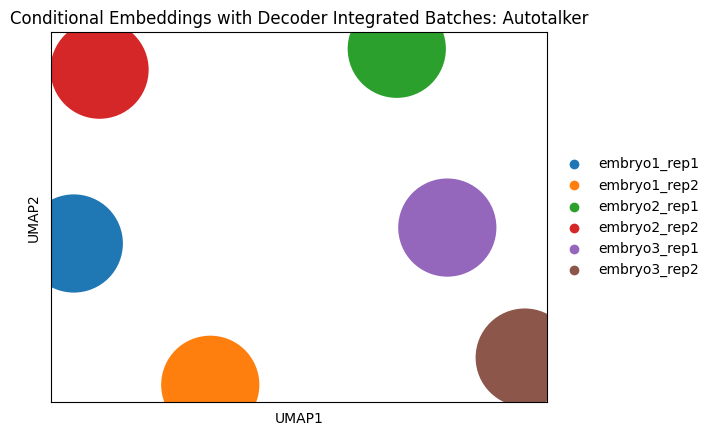

In [62]:
sc.pp.neighbors(adata_cond_embed)
sc.tl.umap(adata_cond_embed)
fig = sc.pl.umap(adata_cond_embed,
                 color=[condition_key],
                 title="Conditional Embeddings with Decoder Integrated Batches: Autotalker",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/cond_embed_autotalker_batches_integrated_decoder.png",
            bbox_inches="tight")

### 3.4 Autotalker Model With Encoder + Decoder Batch Integration

#### 3.4.1 Initialize, Train & Save Model

In [72]:
# Initialize model
model = Autotalker(adata,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   condition_key=condition_key,
                   cond_embed_injection=[#"encoder",
                                         #"gene_expr_decoder",
                                         "graph_decoder"
                                        ],
                   n_cond_embed=3,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   n_hidden_encoder=n_hidden_encoder,
                   n_addon_gps=0,
                   node_label_method="one-hop-attention")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> ['graph_decoder']
GRAPH ENCODER -> n_input: 351, n_cond_embed_input: 0, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 3, n_output: 489, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_cond_embed_input: 0, n_addon_input: 0, n_output: 702


In [ ]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            verbose=True)

--- INITIALIZING TRAINER ---
Number of training nodes: 47311
Number of validation nodes: 5257
Number of training edges: 319410
Number of validation edges: 35490

--- MODEL TRAINING ---
Epoch 1/20 |█-------------------| 5.0% val_auroc_score: 0.9770; val_auprc_score: 0.9561; val_best_acc_score: 0.8742; val_best_f1_score: 0.8882; train_kl_reg_loss: 0.0600; train_edge_recon_loss: 2.4259; train_gene_expr_recon_loss: 101.9959; train_group_lasso_reg_loss: 0.0000; train_global_loss: 104.4818; train_optim_loss: 104.4818; val_kl_reg_loss: 0.0739; val_edge_recon_loss: 2.1005; val_gene_expr_recon_loss: 94.4311; val_group_lasso_reg_loss: 0.0000; val_global_loss: 96.6055; val_optim_loss: 96.6055
Epoch 2/20 |██------------------| 10.0% val_auroc_score: 0.9830; val_auprc_score: 0.9673; val_best_acc_score: 0.8988; val_best_f1_score: 0.9081; train_kl_reg_loss: 0.0913; train_edge_recon_loss: 1.3826; train_gene_expr_recon_loss: 93.7105; train_group_lasso_reg_loss: 0.0000; train_global_loss: 95.1844; train

# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/integrated_encoder_decoder",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

#### 3.3.2 Analyze Latent Space

In [65]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key)
sc.tl.umap(model.adata)

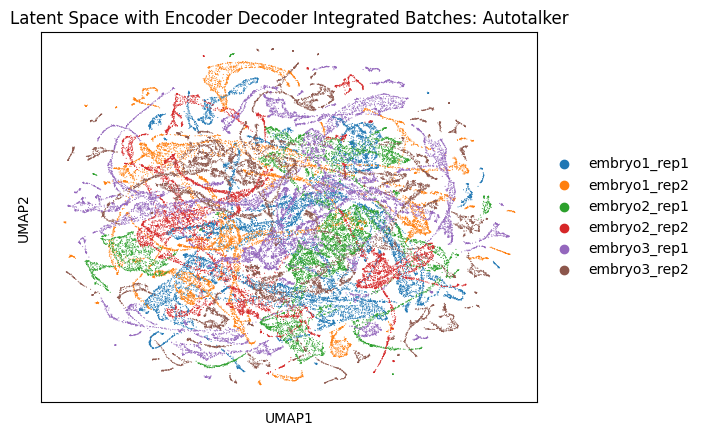

In [66]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(model.adata,
                 color=[condition_key],
                 title="Latent Space with Encoder Decoder Integrated Batches: Autotalker",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_autotalker_batches_integrated_encoder_decoder.png",
            bbox_inches="tight")

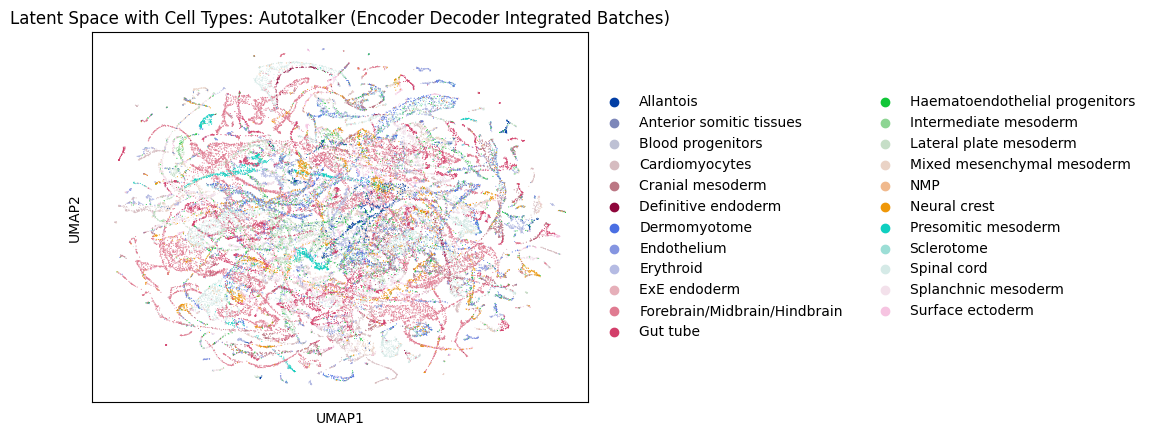

In [67]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 color=[cell_type_key],
                 title="Latent Space with Cell Types: Autotalker (Encoder Decoder Integrated Batches)",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_autotalker_cell_types_integrated_encoder_decoder.png",
            bbox_inches="tight")

#### 3.3.3 Analyze Conditional Embedding

In [34]:
# Get conditional embeddings
cond_embed = model.get_conditional_embeddings()
adata_cond_embed = ad.AnnData(cond_embed)
adata_cond_embed.obs["batch"] = adata.obs["batch"].unique()

         Falling back to preprocessing with `sc.pp.pca` and default params.


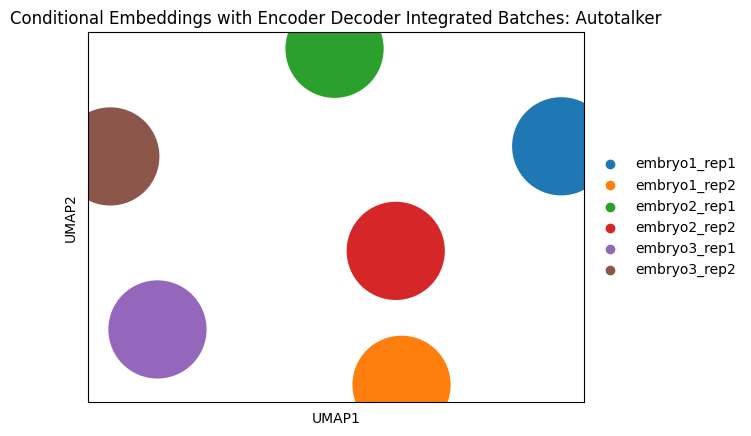

In [35]:
sc.pp.neighbors(adata_cond_embed)
sc.tl.umap(adata_cond_embed)
fig = sc.pl.umap(adata_cond_embed,
                 color=[condition_key],
                 title="Conditional Embeddings with Encoder Decoder Integrated Batches: Autotalker",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/cond_embed_autotalker_batches_integrated_encoder_decoder.png",
            bbox_inches="tight")